In [148]:
import creds
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, log_loss
from hyperopt import hp, tpe, fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split

# Set Pandas options to see all columns
pd.set_option('display.max_columns', None)
seed = 123

In [149]:
con_string = f"postgresql+psycopg2://{creds.DB_USER}:{creds.DB_PASS}@{creds.DB_HOST}/{creds.DB_NAME}"
engine = create_engine(con_string)
conn = engine.connect()
df = pd.read_sql('play_by_play', conn)
conn.close()

In [150]:
df.shape

(329117, 36)

In [151]:
df.columns

Index(['period_x', 'periodTime', 'eventType', 'coordsX', 'coordsY',
       'eventDescription', 'shotType', 'eventPlayer1', 'eventPlayer2',
       'eventPlayer3', 'homeGoals', 'awayGoals', 'eventTeam', 'homeTeam',
       'awayTeam', 'playId', 'period_y', 'strength', 'time', 'event',
       'description', 'home1', 'home2', 'home3', 'home4', 'home5', 'home6',
       'away1', 'away2', 'away3', 'away4', 'away5', 'away6', 'homeGoalie',
       'awayGoalie', 'gameId'],
      dtype='object')

In [152]:
df[['eventType']].value_counts()

eventType   
Faceoff         74657
Shot            74062
Hit             59077
Blocked Shot    38614
Missed Shot     32194
Giveaway        22656
Takeaway        19383
Goal             8474
Name: count, dtype: int64

In [153]:
df['isCorsi'] = np.where(df['eventType'].isin(['Shot', 'Missed Shot', 'Goal']), 1, 0)
df['isOnGoal'] = np.where(df['eventType'].isin(['Shot', 'Goal']), 1, 0)
df['isGoal'] = np.where(df['eventType'].isin(['Goal']), 1, 0)

In [154]:
# Filter out own goals, EN goals, and penalty shots
df['isOwnGoal'] = np.where(df['description'].str.contains("Own Goal"), 1, 0)
df['isEmptyNet'] = np.where(((df['homeGoalie'].isna()) & (df['eventTeam'] == df['awayTeam'])) |
                            ((df['awayGoalie'].isna()) & (df['eventTeam'] == df['homeTeam'])),
                            1, 0)
df['isPenaltyShot'] = np.where(df['description'].str.contains("Penalty Shot"), 1, 0)
df_filtered = df[(df['isOwnGoal'] == 0) & (df['isEmptyNet']==0) & (df['isPenaltyShot']==0) & (df['period_x'] < 4)].copy()

In [155]:
# Add missed shots shotTypes
df_filtered['shotType'] = df_filtered.apply(lambda row: row['description'].split(', ')[1] if row['eventType']=="Missed Shot" else row["shotType"], axis=1)

In [156]:
# These are all goals on dislodged nets
display(df_filtered[(df_filtered['shotType'].isna()) & (df_filtered['eventType'] == "Goal")][['gameId', 'description']])

df_filtered.at[70788, 'shotType'] = "Backhand"
df_filtered.at[168696, 'shotType'] = "Poke"
df_filtered.at[169974, 'shotType'] = "Bat"
df_filtered.at[195853, 'shotType'] = "Wrist"

,gameId,description
70788,2022020276,"TOR #55 GIORDANO(1), Off. Zone, 12 ft.Assists:..."
168696,2022020673,"FLA #21 COUSINS(5), Off. Zone, 4 ft.Assists: #..."
169974,2022020677,"DAL #16 PAVELSKI(13), Off. Zone, 7 ft.Assists:..."
195853,2022020779,"ARI #8 SCHMALTZ(11), Off. Zone, 13 ft."


In [157]:
# Drop missed shots that don't have shotType
df_filtered = df_filtered[~(df_filtered['shotType'] == "Failed Attempt")]

In [158]:
# Create lagged columns 
df_filtered[['lastPeriodTime', 'lastEventType', 'lastCoordsX', 'lastCoordsY', 'lastEventTeam']] = df_filtered[['periodTime', 'eventType', 'coordsX', 'coordsY', 'eventTeam']].shift()

In [159]:
# Create isHome column
df_filtered['isHome'] = np.where(df_filtered['homeTeam'] == df_filtered['eventTeam'], 1, 0)
df_filtered['isHome'].value_counts()

isHome
1    166514
0    155704
Name: count, dtype: int64

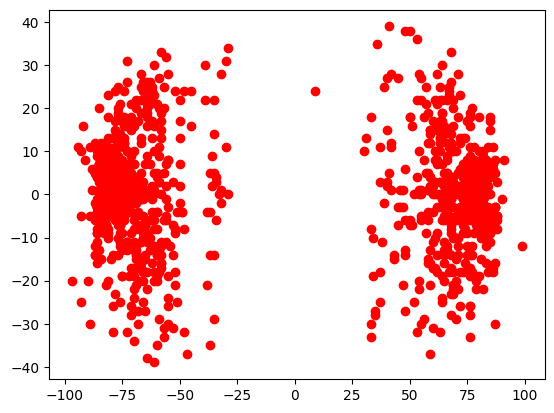

In [160]:
plt.plot('coordsX', 'coordsY','ro', data=df_filtered[(df_filtered['isGoal']==1) & (df_filtered['isHome']==1) & (df_filtered['period_x']==1)])
plt.show()

In [161]:
# Dict to shift x,y coords to same side for all teams
coords_shift_dict = {
    'NSH': 1,
    'CBJ': 1,
    'SJS': 1,
    'WSH': -1,
    'NYR': -1,
    'LAK': -1,
    'CAR': -1,
    'MTL': -1,
    'COL': -1,
    'BUF': 1,
    'ANA': 1,
    'NYI': 1,
    'EDM': 1,
    'PIT': 1,
    'PHI': -1,
    'TOR': -1,
    'MIN': -1,
    'CGY': -1,
    'VGK': -1,
    'DET': -1,
    'DAL': -1,
    'OTT': 1,
    'WPG': -1,
    'BOS': 1,
    'NJD': 1,
    'STL': 1,
    'SEA': 1,
    'FLA': -1,
    'CHI': -1,
    'VAN': -1,
    'TBL': 1,
    'ARI': 1
}
df_filtered['flippedCoordsX'] = df_filtered.apply(lambda row: row['coordsX'] * coords_shift_dict[row['homeTeam']], axis=1)
df_filtered['flippedCoordsY'] = df_filtered.apply(lambda row: row['coordsY'] * coords_shift_dict[row['homeTeam']], axis=1)

# Fix the outdoor game
df_filtered.loc[df_filtered['gameId'] == 2022020595, 'flippedCoordsX'] *= -1
df_filtered.loc[df_filtered['gameId'] == 2022020595, 'flippedCoordsY'] *= -1
# Fix global series game
df_filtered.loc[df_filtered['gameId'] == 2022020001, 'flippedCoordsX'] *= -1
df_filtered.loc[df_filtered['gameId'] == 2022020001, 'flippedCoordsY'] *= -1

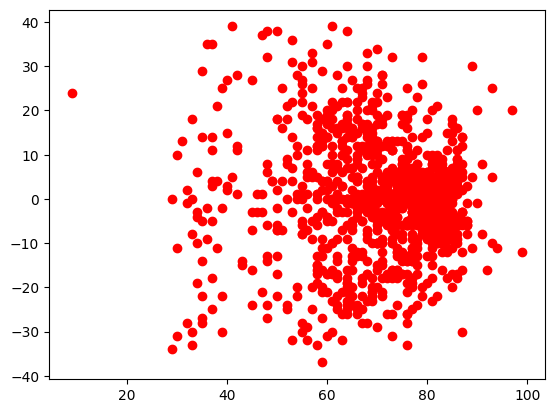

In [162]:
plt.plot('flippedCoordsX', 'flippedCoordsY','ro', data=df_filtered[(df_filtered['isGoal']==1) & (df_filtered['isHome']==1) & (df_filtered['period_x']==1)])
plt.show()

In [163]:
df_corsi = df_filtered[df_filtered['isCorsi']==1].copy()

# Dict to flip all corsi events to one side
flip_coords_dict = {
    (1, 1): 1,
    (1, 2): -1,
    (1, 3): 1,
    (0, 1): -1,
    (0, 2): 1,
    (0, 3): -1,
}
df_corsi['flippedCoordsX'] = df_corsi.apply(lambda row: row['flippedCoordsX'] * flip_coords_dict[(row['isHome'],row['period_x'])], axis=1)
df_corsi['flippedCoordsY'] = df_corsi.apply(lambda row: row['flippedCoordsY'] * flip_coords_dict[(row['isHome'],row['period_x'])], axis=1)


In [164]:
goalX = 88
goalY = 0
df_corsi['distToGoal'] = df_corsi.apply(lambda row: np.sqrt((row['flippedCoordsX'] - goalX)**2 + (row['flippedCoordsY'] - goalY)**2),axis=1)
df_corsi['angleToGoal'] = df_corsi.apply(lambda row: np.degrees(np.arctan2((row['flippedCoordsY'] - goalY), (row['flippedCoordsX'] - goalX)))-90,axis=1)
df_corsi['angleToGoal'] = np.where(df_corsi['angleToGoal'] < -90, np.abs(df_corsi['angleToGoal'])-180, df_corsi['angleToGoal'])


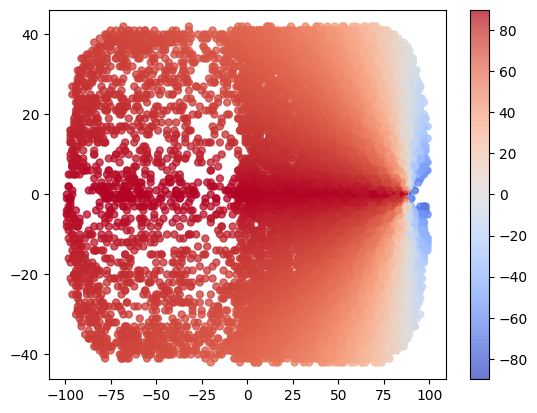

In [165]:
cmap = sns.color_palette("coolwarm", as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(df_corsi['flippedCoordsX'], df_corsi['flippedCoordsY'],c=df_corsi['angleToGoal'], s=25, cmap=cmap, alpha=.75)
f.colorbar(points)
plt.show()

In [204]:
df_corsi['lastEventSameTeam'] = np.where(df_corsi['lastEventTeam'] == df_corsi['eventTeam'], 1, 0)
df_corsi['distFromLastEvent'] = np.sqrt((df_corsi['coordsX']-df_corsi['lastCoordsX'])**2 + (df_corsi['coordsY']-df_corsi['lastCoordsY'])**2)
df_corsi['timeFromLastEvent'] = df_corsi['periodTime'] - df_corsi['lastPeriodTime']

# Create more features
df_corsi['reboundOffBlock3Seconds'] = np.where((df_corsi['lastEventType'] == 'Blocked Shot') & (df_corsi['timeFromLastEvent'] < 3), 1, 0)
df_corsi['reboundOffBlock2Seconds'] = np.where((df_corsi['lastEventType'] == 'Blocked Shot') & (df_corsi['timeFromLastEvent'] < 2), 1, 0)
df_corsi['reboundOffBlock1Seconds'] = np.where((df_corsi['lastEventType'] == 'Blocked Shot') & (df_corsi['timeFromLastEvent'] < 1), 1, 0)

df_corsi['rebound3Seconds'] = np.where((df_corsi['lastEventType'] == 'Shot') & (df_corsi['timeFromLastEvent'] < 3), 1, 0)
df_corsi['rebound2Seconds'] = np.where((df_corsi['lastEventType'] == 'Shot') & (df_corsi['timeFromLastEvent'] < 2), 1, 0)
df_corsi['rebound1Seconds'] = np.where((df_corsi['lastEventType'] == 'Shot') & (df_corsi['timeFromLastEvent'] < 1), 1, 0)

df_corsi['breakawayShot'] = np.where((df_corsi['distFromLastEvent'] > 30) & (df_corsi['timeFromLastEvent'] < 5), 1, 0)


In [205]:
df_corsi['strength'].value_counts()
df_EV = df_corsi[(df_corsi['strength']=='EV') & (df_corsi['isOnGoal']=='1')]
df_PP = df_corsi[df_corsi['strength']=='PP']
df_SH = df_corsi[df_corsi['strength']=='SH']

In [224]:
def get_model(df):
    columns_to_drop = ['eventType', 'eventDescription', 'eventPlayer1', 'eventPlayer2',
       'eventPlayer3', 'homeGoals', 'awayGoals', 'eventTeam', 'homeTeam',
       'awayTeam', 'playId', 'period_y', 'strength', 'event', 'description', 
       'home1', 'home2', 'home3', 'home4', 'home5', 'home6', 'away1', 'away2', 
       'away3', 'away4', 'away5', 'away6', 'homeGoalie', 'gameId', 'isCorsi', 'isGoal', 'isOwnGoal', 'isEmptyNet','lastEventTeam',
       'isPenaltyShot', 'awayGoalie']
    X = df.drop(columns=columns_to_drop, axis='columns')
    y = df['isGoal']

    categorical_columns = ['shotType','lastEventType']

    X_encoded = pd.get_dummies(X, columns=categorical_columns,dummy_na=True)

    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=seed)

    space = {'n_estimators':hp.quniform('n_estimators', 10, 1000, 10),
        'learning_rate':hp.uniform('learning_rate', 0.001, 0.2),
         'max_depth':hp.quniform('max_depth', 3,7,1),
         'subsample':hp.uniform('subsample', 0.25, 0.95),
         'colsample_bytree':hp.uniform('colsample_bytree', 0.25, 0.95),
         'reg_lambda': hp.uniform('reg_lambda', 1, 20),
         'scale_pos_weight': hp.uniform('scale_pos_weight', .5, 10) # Used for class imbalance 
        }

    def objective(params):
        params = {'n_estimators': int(params['n_estimators']),
                'learning_rate': params['learning_rate'],
                'max_depth': int(params['max_depth']),
                'subsample': params['subsample'],
                'colsample_bytree': params['colsample_bytree'],
                'reg_lambda': params['reg_lambda'],
                'scale_pos_weight': params['scale_pos_weight']
                }
        
        xbg= XGBClassifier(**params)
        cv = StratifiedKFold(10)
        score = cross_val_score(xbg, X_train, y_train, scoring='neg_log_loss', cv=cv, n_jobs=-1).mean()
        return -score
    
    best = fmin(fn= objective, space=space, max_evals=15, rstate=np.random.default_rng(seed=seed), algo=tpe.suggest)
    
    final_xgb = XGBClassifier(
        random_state=seed,
        n_estimators=int(best['n_estimators']),
        learning_rate=best['learning_rate'],
        max_depth=int(best['max_depth']),
        subsample=best['subsample'],
        colsample_bytree=best['colsample_bytree'],
        reg_lambda=best['reg_lambda'],
        scale_pos_weight=best['scale_pos_weight']
    )
    return final_xgb, X_train, X_test, y_train, y_test

In [223]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [226]:
final_xgb_EV, X_train_EV, X_test_EV, y_train_EV, y_test_EV = get_model(df_EV)
final_xgb_EV.fit(X_train_EV, y_train_EV)
y_pred_prob_EV = final_xgb_EV.predict_proba(X_test_EV)
print("ROC_AUC: {}".format(roc_auc_score(y_test_EV, y_pred_prob_EV[:,1])))
print("Log loss: {}".format(log_loss(y_test_EV, y_pred_prob_EV[:,1])))
print("Actual - Expected: {}".format(sum(y_test_EV) - sum(y_pred_prob_EV[:,1])))

100%|██████████| 15/15 [08:52<00:00, 35.52s/trial, best loss: 0.187836196668797]
ROC_AUC: 0.8249212432272047
Log loss: 0.18818945874329607
Actual - Expected: 197.6900742918533


In [227]:
final_xgb_PP, X_train_PP, X_test_PP, y_train_PP, y_test_PP = get_model(df_PP)
final_xgb_PP.fit(X_train_PP, y_train_PP)
y_pred_prob_PP = final_xgb_PP.predict_proba(X_test_PP)
print("ROC_AUC: {}".format(roc_auc_score(y_test_PP, y_pred_prob_PP[:,1])))
print("Log loss: {}".format(log_loss(y_test_PP, y_pred_prob_PP[:,1])))
print("Actual - Expected: {}".format(sum(y_test_PP) - sum(y_pred_prob_PP[:,1])))

100%|██████████| 15/15 [01:38<00:00,  6.54s/trial, best loss: 0.28364141594543224]
ROC_AUC: 0.7526997907818744
Log loss: 0.28586031728456335
Actual - Expected: 58.237378018398886


In [228]:
final_xgb_SH, X_train_SH, X_test_SH, y_train_SH, y_test_SH = get_model(df_SH)
final_xgb_SH.fit(X_train_SH, y_train_SH)
y_pred_prob_SH = final_xgb_SH.predict_proba(X_test_SH)
print("ROC_AUC: {}".format(roc_auc_score(y_test_SH, y_pred_prob_SH[:,1])))
print("Log loss: {}".format(log_loss(y_test_SH, y_pred_prob_SH[:,1])))
print("Actual - Expected: {}".format(sum(y_test_SH) - sum(y_pred_prob_SH[:,1])))

100%|██████████| 15/15 [00:17<00:00,  1.17s/trial, best loss: 0.21941560037494137]
ROC_AUC: 0.801994301994302
Log loss: 0.2467934453608191
Actual - Expected: 16.136428712299676


In [ ]:
df_encoded_EV = pd.get_dummies(df_EV, columns=['shotType','lastEventType'],dummy_na=True)
predictions = final_xgb_EV.predict_proba(df_encoded_EV.drop(columns=['shotType','lastEventType'], axis='columns'))
df_encoded_EV['xG'] = predictions[:,1]

In [220]:
df_encoded_EV_grp = df_encoded_EV.groupby(by='eventPlayer1').agg({'xG': sum, "isGoal": sum})
df_encoded_EV_grp['goalsAboveExpected'] = df_encoded_EV_grp['isGoal'] - df_encoded_EV_grp['xG']
df_encoded_EV_grp[df_encoded_EV_grp['isGoal']> 10].sort_values(by='goalsAboveExpected', ascending=True).head(10)

,xG,isGoal,goalsAboveExpected
eventPlayer1,,,
8475786,23.730070,15,-8.730070
8476399,15.289220,12,-3.289220
8480002,18.918459,16,-2.918459
8476389,13.806836,11,-2.806836
8475810,17.615425,15,-2.615425
8474150,15.404436,13,-2.404436
8477935,13.358200,11,-2.358200
8475166,18.226439,16,-2.226439
8470610,15.122750,13,-2.122750


In [221]:
# df_encoded['eventGoalie'] = np.where(df_encoded['eventTeam']==df_encoded['homeTeam'],df_encoded['awayGoalie'], df_encoded['homeGoalie'])
# df_encoded_grp = df_encoded.groupby(by='eventGoalie').agg({'xG': sum, "isGoal": sum})
# df_encoded_grp['goalsAboveExpected'] = df_encoded_grp['isGoal'] - df_encoded_grp['xG']
# df_encoded_grp[df_encoded_grp['isGoal'] > 20].sort_values(by='goalsAboveExpected', ascending=True).head(15)

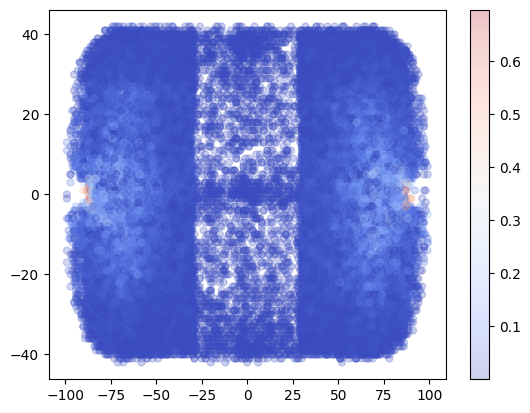

In [231]:
cmap = sns.color_palette("coolwarm", as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(df_encoded_EV['coordsX'], df_encoded_EV['coordsY'],c=df_encoded_EV['xG'], s=25, cmap=cmap, alpha=.25)
f.colorbar(points)
plt.show()